# EEG Signal Preprocessing Notebook

## 1️⃣ Import Libraries & Set Paths
- Import Python packages: `numpy`, `pandas`, `matplotlib`, `scipy.signal`, `os`, `re`, `pathlib`
- Set raw data directory path
- Optional: set random seed for reproducibility

---

## 2️⃣ Understand Dataset
- Data format: `sXX_exXX_sXX.txt`
  - `s` = subject number  
  - `ex` = experiment number  
  - `s` = session number (only for ex01/ex02)  
- 4 EEG channels: **T7, F8, Cz, P4**  
- Sampling rate: **200 Hz**  
- Electrodes: **Gold Cup with Ten20 conductive paste**  
- Check for header row (`Sample, T7, F8, Cz, P4`)  
- Plan how to handle headers when loading the file

---

## 3️⃣ Load EEG Data
- Function to read any EEG file:
  - Skip headers or non-numeric columns
  - Return `sample_idx` (column 0) and `eeg_data` (columns 1–4)
- Ensure flexibility to load files from any experiment

---

## 4️⃣ Initial Visualization
- Plot raw EEG signals
  - Stack channels with offsets
  - Optionally plot individual channels
- Observe noise, artifacts, offsets, and amplitude differences

---

## 5️⃣ Signal Preprocessing
**5a. Offset / Detrend (Optional)**  
- Remove DC offset or baseline drift if needed  

**5b. Bandpass Filtering**  
- Apply **Butterworth 1–40 Hz filter**  
- Use `filtfilt` for zero-phase distortion  

**5c. Optional Notch Filter**  
- Remove **50 Hz line noise** if present  

---

## 6️⃣ Artifact Handling
- Identify/remove spikes or unusual peaks
- Optional: simulate motion artifacts for modeling

---

## 7️⃣ Feature Extraction
- **Time-domain features:** RMS, Peak-to-Peak, Mean, Std  
- **Frequency-domain features:** FFT, band power (delta, theta, alpha, beta)

---

## 8️⃣ Parameter Sweep / System Modeling
- Add Gaussian noise at varying levels
- Adjust filter cutoffs and observe effects on signal quality
- Visualize impact across channels

---

## 9️⃣ Save Preprocessed Data
- Save filtered EEG arrays for future analysis
- Maintain folder structure:
  - `raw/`  
  - `filtered/`  
  - `segmented/` (if applicable)

---

## Notes / References
- Jurcak V, Tsuzuki D, Dan I. 10/20, 10/10, and 10/5 systems revisited: their validity as relative head-surface-based positioning systems. Neuroimage. 2007 Feb 15;34(4):1600-11.
Altahat SH. Robust EEG Channel Set for Biometric Application (Doctoral dissertation, University of Canberra).
Ravi KV, Palaniappan R. A minimal channel set for individual identification with EEG biometric using genetic algorithm. InInternational Conference on Computational Intelligence and Multimedia Applications (ICCIMA 2007) 2007 Dec 13 (Vol. 2, pp. 328-332). IEEE.
Marcel S, Millán JD. Person authentication using brainwaves (EEG) and maximum a posteriori model adaptation. IEEE transactions on pattern analysis and machine intelligence. 2007 Feb 20;29(4):743-52.
World Medical Association. World Medical Association Declaration of Helsinki. Ethical principles for medical research involving human subjects. Bulletin of the World Health Organization. 2001;79(4):373.


## 1️⃣ Import Libraries and Set Paths

In [15]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd

## 3️⃣ Load EEG Data & 4️⃣ Initial Visualization

In [16]:
# Define a general function to open any EEG data file given its path
def load_eeg_file(exp_folder, filename):
    """
    Load an EEG data file based on its experiment folder and filename.

    Parameters:
    ------------
    exp_folder: str or Path 
        Path to the experiment folder (e.g., "data\auditory-evoked-potential-eeg-biometric-dataset-1.0.0\Raw_Data\ex01")
    
    filename: str 
        Name of the file to load (e.g., "s01_ex01_s01.txt")
    
    Returns:
    --------
    sample_idx : np.ndarray
        Array of sample indices
    eeg : np.ndarray
        EEG signal array (num_samples x num_channels)
    """
    exp_folder = Path(exp_folder)
    file_path = exp_folder / filename

    # Load file
    try:
        df = pd.read_csv(file_path, sep=",")
    except Exception as e:
        raise ValueError(f"Could not load file {file_path}: {e}")

    # Split sample index and EEG channels
    sample_idx = df.iloc[:, 0].to_numpy()
    eeg = df.iloc[:, 1:5].to_numpy()  # 4 EEG channels

    return sample_idx, eeg
# -----------------------------------------------------------------------------------------------------------------------------------------------------
# Define a function to plot EEG signals for all or selected channels
def plot_eeg(sample_idx, eeg, channels_to_plot=None, channel_names=None):
    """
    Plot EEG signals with optional channel selection and offsets.

    Parameters:
    - sample_idx: array of sample indices
    - eeg: numpy array of shape (n_samples, n_channels)
    - channels_to_plot: list of channel indices to plot (0-based). If None, plot all.
    - channel_names: list of names for channels. If None, default to Ch1, Ch2...
    """
    n_channels = eeg.shape[1]

    if channels_to_plot is None:
        channels_to_plot = list(range(n_channels))

    if channel_names is None:
        channel_names = [f"Ch{i+1}" for i in range(n_channels)]

    plt.figure(figsize=(12, 6))
    
    for i, ch_idx in enumerate(channels_to_plot):
        plt.plot(sample_idx, eeg[:, ch_idx] + i*50, label=channel_names[ch_idx])  # offset

    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude + Offset (+ 50 uV)")
    plt.title("EEG Signals")
    plt.legend()
    plt.show()

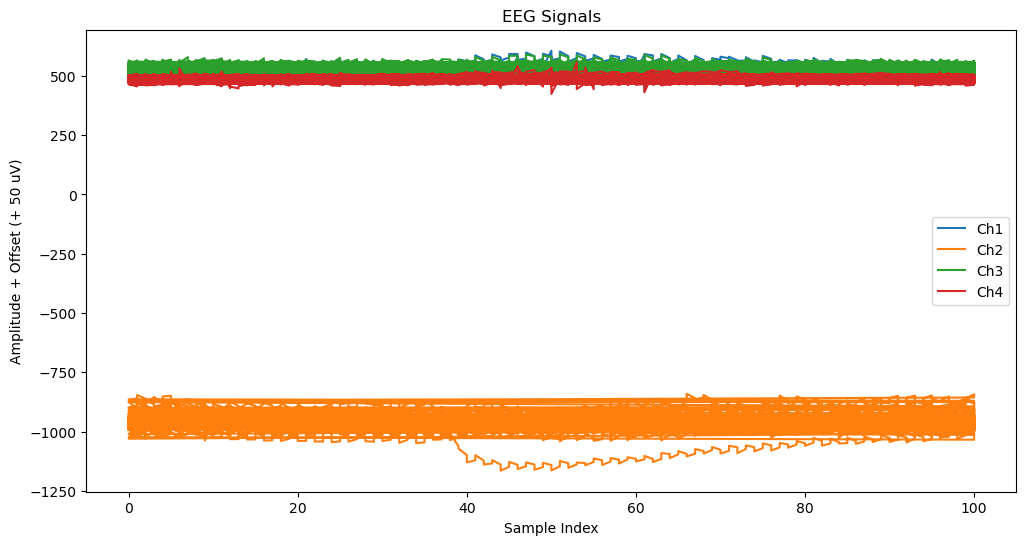

In [17]:
# Define the path to the raw data directory
raw = Path("data") / "auditory-evoked-potential-eeg-biometric-dataset-1.0.0" / "Raw_Data"

# Load any file from ex09
sample_idx, eeg = load_eeg_file(raw / "ex01", "s01_ex01_s01.txt")

# Plot all channels
plot_eeg(sample_idx, eeg)


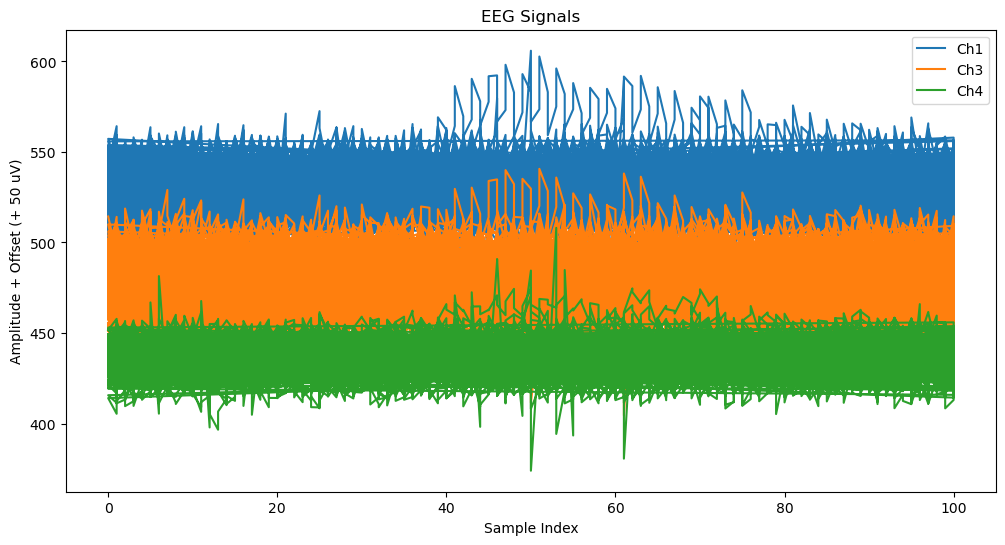

In [18]:
# Plot all channels
plot_eeg(sample_idx, eeg, channels_to_plot=[0, 2, 3])

## 5️⃣ Signal Pre-processing

Its clear that the raw data has noise. We can intoduce a bandpass filter to remove low frequencies and very high frequencies. 

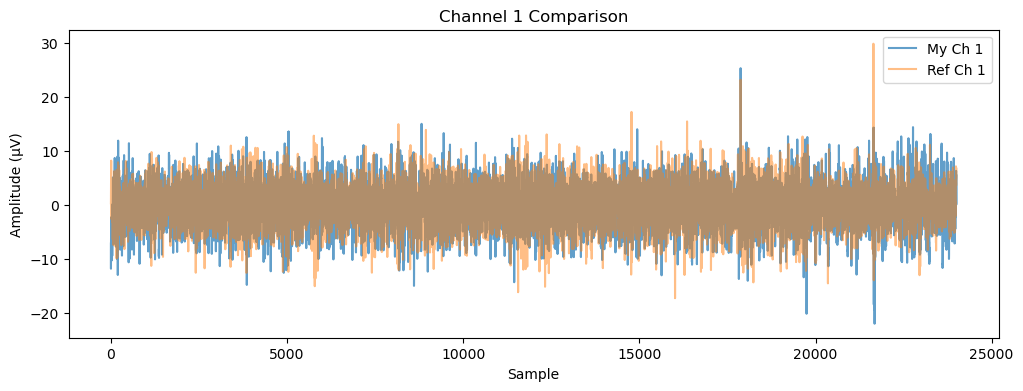

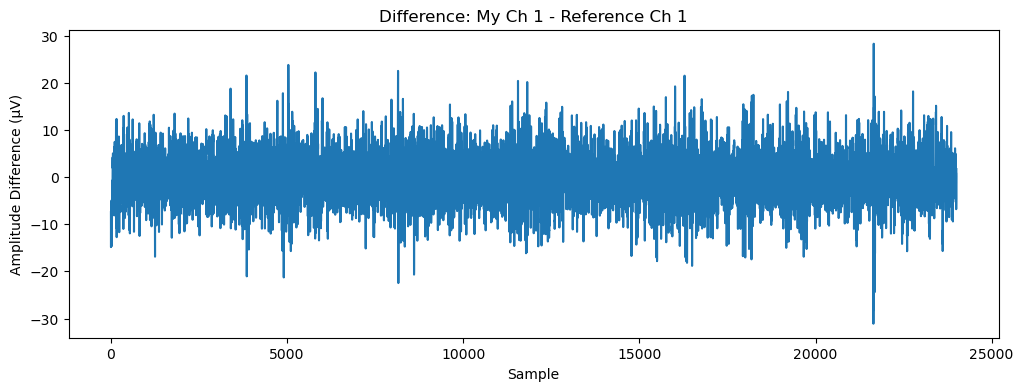

Max difference: 28.26044 µV, Mean difference: -0.01878 µV
Channel 1 correlation with reference: 0.104663


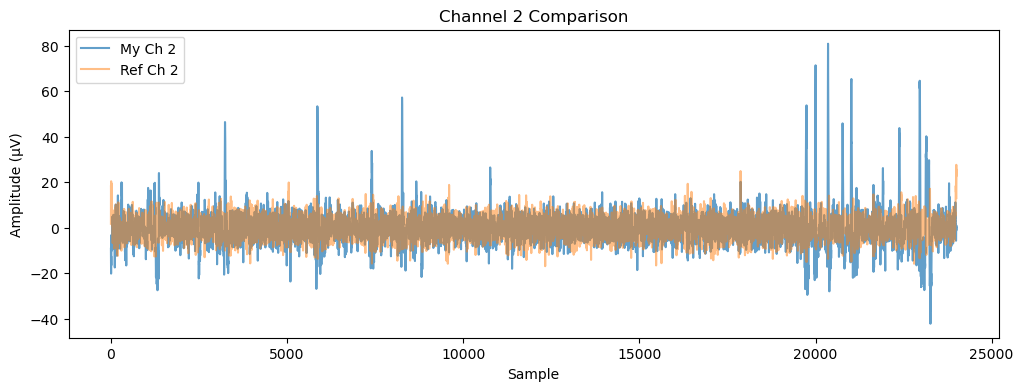

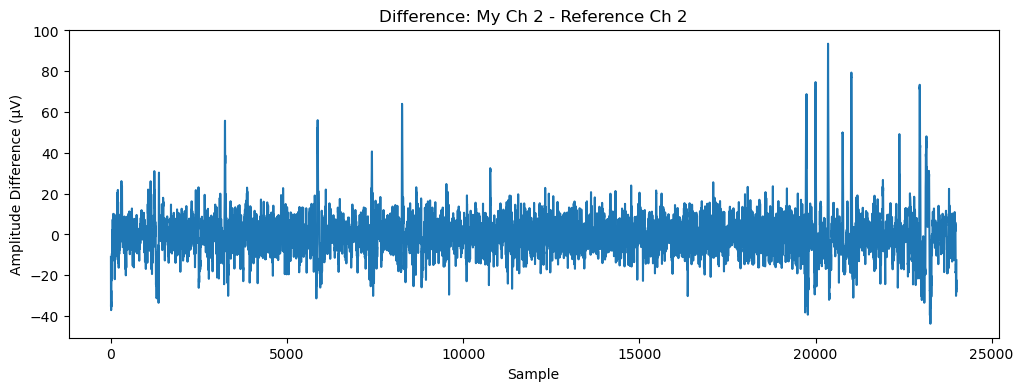

Max difference: 93.47756 µV, Mean difference: -0.05845 µV
Channel 2 correlation with reference: -0.247674


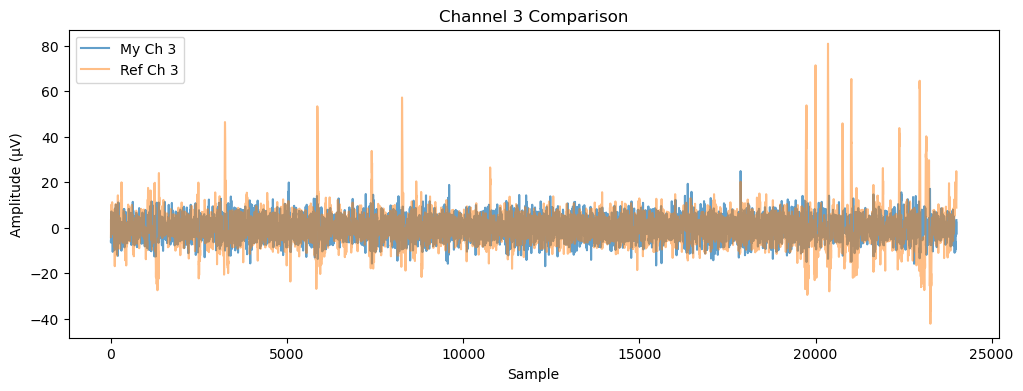

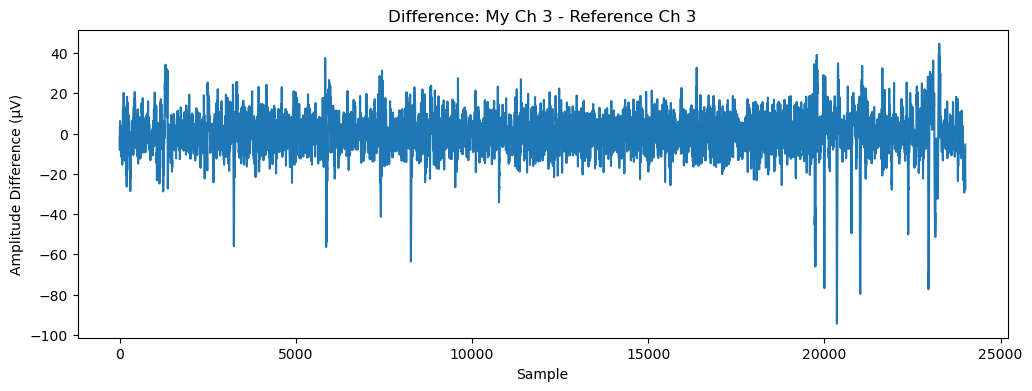

Max difference: 44.66660 µV, Mean difference: -0.05979 µV
Channel 3 correlation with reference: -0.299610


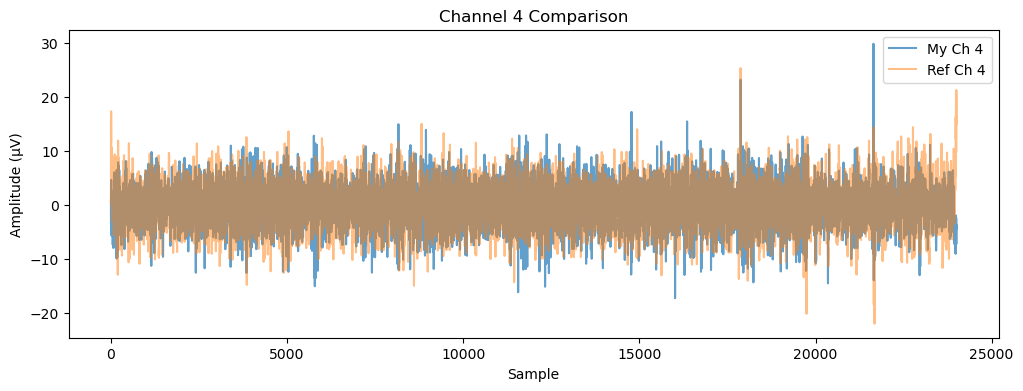

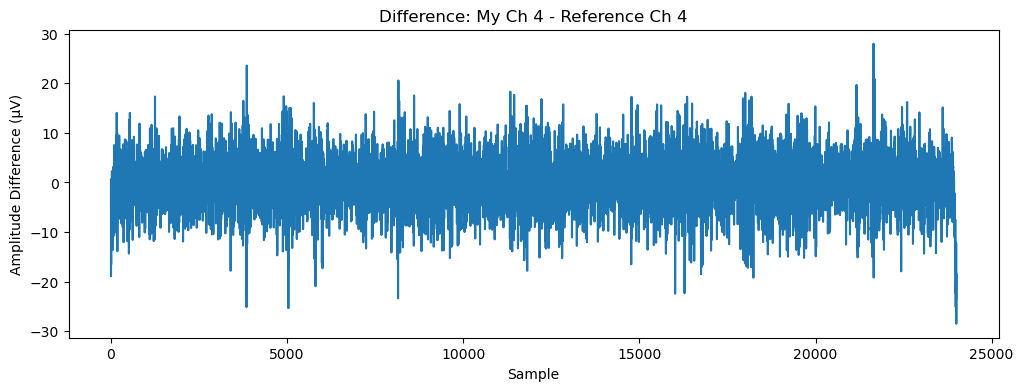

Max difference: 27.96727 µV, Mean difference: -0.05588 µV
Channel 4 correlation with reference: 0.090452


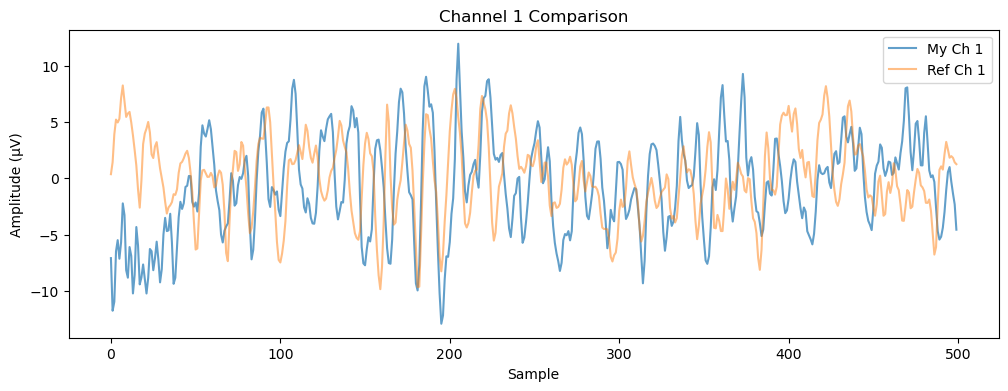

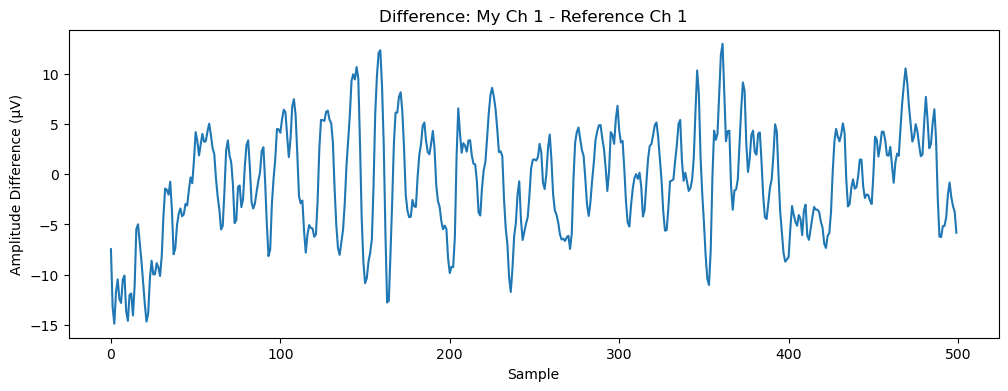

Max difference: 12.96301 µV, Mean difference: -0.73674 µV
Channel 1 correlation with reference: 0.071678


In [22]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
from pathlib import Path
import matplotlib.pyplot as plt

# --- Paths ---
raw_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Raw_Data")
trim_file = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/data_trim.csv")
filtered_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data")

# --- Sampling rate ---
fs = 200  # Hz

# --- Filters ---
def bandpass_1_40hz(data, fs):
    """1st-order Butterworth bandpass 1-40 Hz"""
    low, high = 1, 40
    b, a = butter(1, [low / (0.5*fs), high / (0.5*fs)], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_50hz(data, fs):
    """50 Hz notch filter with Q=30"""
    f0 = 50
    Q = 30
    b, a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b, a, data, axis=0)

# --- Load trim points ---
trim_df = pd.read_csv(trim_file)

def get_trim_indices(subject, experiment, session):
    """
    Return start/end sample indices from data_trim.csv
    Uses 'From (n)' and 'To (n)' columns.
    """
    row = trim_df[
        (trim_df['Subject'] == subject) &
        (trim_df['Experment'] == experiment) &
        (trim_df['session'] == session)
    ]
    if row.empty:
        raise ValueError(f"No trim info for Subject {subject}, Experiment {experiment}, Session {session}")
    
    start_sample = int(row['From (n)'].values[0])
    end_sample   = int(row['To (n)'].values[0])
    return start_sample, end_sample

# --- Load raw EEG ---
def load_raw_eeg(file_path):
    data = pd.read_csv(file_path)
    # Drop header, take numeric columns only (Sample + 4 EEG channels)
    return data.iloc[:, :5].to_numpy()  # [Sample, Ch1, Ch2, Ch3, Ch4]

# --- Preprocess raw EEG ---
# --- OpenBCI Ganglion scaling ---
SCALE_FACTOR = 0.001869917138805  # µV per raw count

def preprocess_eeg(raw_file, subject, experiment, session):
    # 1. Load raw
    data = load_raw_eeg(raw_file)
    
    # 2. Trim
    start, end = get_trim_indices(subject, experiment, session)
    trimmed = data[start:end, 1:]  # EEG channels only
    
    # 2a. Scale raw counts to uV 
    #trimmed = trimmed * SCALE_FACTOR
    
    # 3. Bandpass
    bp = bandpass_1_40hz(trimmed, fs)
    
    # 4. Notch
    filtered = notch_50hz(bp, fs)
    
    return filtered

def compare_with_reference(my_eeg, reference_file, channel=0, window=None, show_diff=True, show_corr=True):
    """
    Compare my EEG vs reference for a single channel.
    
    Parameters:
    - my_eeg: np.ndarray, preprocessed EEG
    - reference_file: path to reference CSV
    - channel: int, which channel to compare (0–3)
    - window: int or None, number of samples to zoom in (None = full signal)
    - show_diff: bool, whether to plot difference
    - show_corr: bool, whether to print correlation
    """
    ref = pd.read_csv(reference_file).iloc[:, channel+1].to_numpy()
    
    # Zoom window if requested
    if window is not None:
        my_plot = my_eeg[:window, channel]
        ref_plot = ref[:window]
    else:
        my_plot = my_eeg[:, channel]
        ref_plot = ref
    
    # Overlay plot
    plt.figure(figsize=(12,4))
    plt.plot(my_plot, label=f"My Ch {channel+1}", alpha=0.7)
    plt.plot(ref_plot, label=f"Ref Ch {channel+1}", alpha=0.5)
    plt.title(f"Channel {channel+1} Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.show()
    
    # Plot difference if requested
    if show_diff:
        diff = my_plot - ref_plot
        plt.figure(figsize=(12,4))
        plt.plot(diff)
        plt.title(f"Difference: My Ch {channel+1} - Reference Ch {channel+1}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude Difference (µV)")
        plt.show()
        print(f"Max difference: {np.max(diff):.5f} µV, Mean difference: {np.mean(diff):.5f} µV")
    
    # Correlation if requested
    if show_corr:
        corr = np.corrcoef(my_plot, ref_plot)[0,1]
        print(f"Channel {channel+1} correlation with reference: {corr:.6f}")

# --- View channels ---
subject = 1
experiment = 1
session = 1
raw_file = raw_dir / f"s{subject:02d}_ex{experiment:02d}_s{session:02d}.txt"
ref_file = filtered_dir / f"s{subject:02d}_ex{experiment:02d}_s{session:02d}.csv"

my_eeg = preprocess_eeg(raw_file, subject, experiment, session)

# Compare all channels
for ch in range(4):
    # Full signal with difference and correlation
    compare_with_reference(my_eeg, ref_file, channel=ch)

# Or zoom in to first 500 samples
compare_with_reference(my_eeg, ref_file, channel=0, window=500)


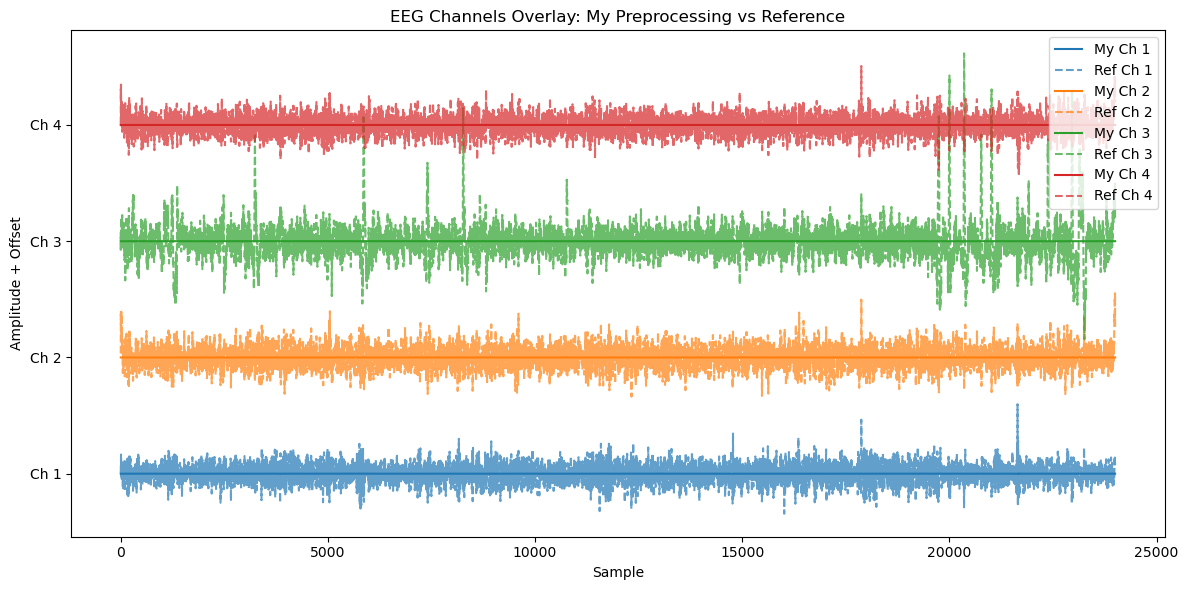

In [20]:
# --- Comparison plot with overlay for all channels ---
def compare_all_channels_overlay(my_eeg, reference_file, offset=50):
    """
    Plot all channels stacked with offsets, overlaying reference data.
    
    Parameters:
        my_eeg: np.array, shape (samples, channels)
        reference_file: path to filtered CSV
        offset: vertical spacing between channels
    """
    ref = pd.read_csv(reference_file).iloc[:, 1:5].to_numpy()  # Channels 1-4
    n_channels = my_eeg.shape[1]

    plt.figure(figsize=(12, 6))
    
    for ch in range(n_channels):
        # Offset each channel
        plt.plot(my_eeg[:, ch] + ch*offset, label=f"My Ch {ch+1}", color=f"C{ch}")
        plt.plot(ref[:, ch] + ch*offset, label=f"Ref Ch {ch+1}", alpha=0.7, linestyle='--', color=f"C{ch}")
    
    # Y-axis labels at center of each channel trace
    yticks = [ch*offset for ch in range(n_channels)]
    ylabels = [f"Ch {ch+1}" for ch in range(n_channels)]
    plt.yticks(yticks, ylabels)
    
    plt.title("EEG Channels Overlay: My Preprocessing vs Reference")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude + Offset")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

compare_all_channels_overlay(my_eeg, ref_file, offset=50)


In [10]:
# Check Signal Stats
# --- Load reference EEG ---
ref_eeg = pd.read_csv(ref_file).iloc[:, 1:5].to_numpy()  # Channels 1-4

# --- Compute stats per channel ---
stats = []

for ch in range(4):
    my_ch = my_eeg[:, ch]
    ref_ch = ref_eeg[:, ch]
    
    mean_diff = np.mean(my_ch - ref_ch)
    std_diff  = np.std(my_ch - ref_ch)
    max_diff  = np.max(np.abs(my_ch - ref_ch))
    rmse      = np.sqrt(np.mean((my_ch - ref_ch)**2))
    
    stats.append({
        "Channel": f"Ch{ch+1}",
        "Mean (My)": np.mean(my_ch),
        "Mean (Ref)": np.mean(ref_ch),
        "Std (My)": np.std(my_ch),
        "Std (Ref)": np.std(ref_ch),
        "Mean Diff": mean_diff,
        "Std Diff": std_diff,
        "Max Abs Diff": max_diff,
        "RMSE": rmse
    })

stats_df = pd.DataFrame(stats)
print(stats_df)



  Channel  Mean (My)  Mean (Ref)  Std (My)  Std (Ref)  Mean Diff  Std Diff  \
0     Ch1  -0.011460    0.007325  3.864844   3.795619  -0.018785  5.125723   
1     Ch2  -0.008282    0.050167  7.543043   4.419444  -0.058449  9.640639   
2     Ch3  -0.011410    0.048377  4.353897   7.565008  -0.059787  9.794001   
3     Ch4  -0.015101    0.040776  3.800425   3.902474  -0.055878  5.195146   

   Max Abs Diff      RMSE  
0     31.105931  5.125757  
1     93.477564  9.640816  
2     94.452365  9.794183  
3     28.487195  5.195447  


In [11]:
# --- Correlation per channel ---
corrs = []

for ch in range(4):
    my_ch = my_eeg[:, ch]
    ref_ch = ref_eeg[:, ch]
    
    corr = np.corrcoef(my_ch, ref_ch)[0, 1]  # Pearson correlation
    corrs.append({"Channel": f"Ch{ch+1}", "Correlation": corr})

corr_df = pd.DataFrame(corrs)
print(corr_df)


  Channel  Correlation
0     Ch1     0.104663
1     Ch2    -0.247674
2     Ch3    -0.299610
3     Ch4     0.090452


In [12]:
print("My EEG Ch1 first 10 samples:", my_eeg[:10,0])
print("Ref EEG Ch1 first 10 samples:", ref_eeg[:10,0])


My EEG Ch1 first 10 samples: [ -7.08970664 -11.75930649 -10.96141315  -6.49161664  -5.49453678
  -7.1418042   -5.67192906  -2.2284367   -3.27091219  -8.16008712]
Ref EEG Ch1 first 10 samples: [0.36366962 1.43166402 3.89813518 5.21246434 4.95609567 5.28030158
 7.1199476  8.24342417 6.808099   5.4488645 ]


In [14]:
trimmed = ref_eeg[:, 1:]  # EEG channels only
print("Raw first 10 samples Ch1:", trimmed[:10,0])
ganglion_scale_factor = 15686 / 8388607
trimmed_scaled = trimmed * ganglion_scale_factor
print("Scaled first 10 samples Ch1:", trimmed_scaled[:10,0])


Raw first 10 samples Ch1: [ 1.73701432 13.11275927 18.65439245 17.26714975 14.27459593 16.31803228
 20.41258485 19.01954637 14.54271635 15.44272224]
Scaled first 10 samples Ch1: [0.00324807 0.02451977 0.03488217 0.03228814 0.02669231 0.03051337
 0.03816984 0.03556498 0.02719367 0.02887661]


In [ ]:
start, end = get_trim_indices(subject, experiment, session)
print("Trim indices:", start, end, "Length:", end-start)
print("Ref EEG length:", ref_eeg.shape[0])


Trim indices: 9000 33000 Length: 24000
Ref EEG length: 24000


: 